In [1]:
import sys
sys.path.append('/Users/nicholebarry/MWA/PyFHD/PyFHD/io')
sys.path.append('/Users/nicholebarry/MWA/PyFHD/PyFHD/use_idl_fhd')
sys.path.append('/Users/nicholebarry/MWA/PyFHD/PyFHD/pyfhd_tools')
print(sys.path)

['/Users/nicholebarry/MWA/python_scripts', '/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python311.zip', '/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11', '/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/lib-dynload', '', '/Users/nicholebarry/miniconda3/envs/python_graphics/lib/python3.11/site-packages', '/Users/nicholebarry/MWA/PyFHD/PyFHD/io', '/Users/nicholebarry/MWA/PyFHD/PyFHD/use_idl_fhd', '/Users/nicholebarry/MWA/PyFHD/PyFHD/pyfhd_tools']


In [2]:
from pyfhd_io import save, load
from use_idl_outputs import convert_sav_to_dict
from pyfhd_io import recarray_to_dict
from pyfhd_setup import pyfhd_logger
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import colors
import numpy as np
from colormaps import spectral
from matplotlib.colors import ColorConverter

# Font properties
# Note: TNR required for bolding due to font manager bug
# Math font for compact, times-like scientific notation
# Exit out of notebook before changing
times_font=True
if times_font:
    font_bold = fm.FontProperties(family='Times New Roman', style='normal', size=32, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Times', style='normal', size=14, weight='normal', stretch='normal')
    font_name ='Times'
    plt.rcParams["mathtext.fontset"] = "stixsans"
    plt.rcParams['font.family'] = 'Times'
else:
    font_name ='Dejavu Sans'
    font_bold = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='normal', stretch='normal')  

# Set defaults for plot font and size
matplotlib.rc('font', size=26)
matplotlib.rc('axes', labelsize=26)    
    
# Color map
cb_spec, cb_spec_r = spectral()
cb_spec.set_bad('white')


## Plotting parameters for colors and plot locations
# Spectral custom colors
ColorConverter.colors['e']=(94/256, 79/256, 162/256)
ColorConverter.colors['g']=(50/256, 136/256, 189/256)
ColorConverter.colors['h']=(102/256, 194/256, 165/256)
ColorConverter.colors['i']=(253/256, 174/256, 97/256)
ColorConverter.colors['j']=(219/256, 55/256, 82/256)
ColorConverter.colors['k']=(37/256, 42/256, 70/256)

In [3]:
def get_obs():
    with open('/Users/nicholebarry/MWA/data/pyfhd_compare/10_ssins.txt') as f:
        lines = [line.rstrip() for line in f]

        if len(lines) > 0:
            if lines[0] != '':
                obs_list = lines
                
    return obs_list
            
def sav_to_h5():

    pyfhd_config = load(f'/Users/nicholebarry/MWA/data/pyfhd_compare/1088288648_config.h5')
    pyfhd_config['output_path'] = '/Users/nicholebarry/MWA/data/pyfhd_compare/'
    logger, output_dir = pyfhd_logger(pyfhd_config)

    #cal_fhd_list = []
    cal = load(f'/Users/nicholebarry/MWA/data/pyfhd_compare/pyfhd/{obs_list[0]}_cal.h5')
    pyfhd_cal_set = set(cal_list[0])

    n_tiles = 128
    n_pol = 2

    for obs_id in obs_list:
        cal_fhd = convert_sav_to_dict(f'/Users/nicholebarry/MWA/data/pyfhd_compare/fhd/{obs_id}_cal.sav', logger)
        cal_fhd = cal_fhd['cal']
        cal_fhd = recarray_to_dict(cal_fhd)

        #cal_fhd_list.append(cal_fhd)
        fhd_cal_set = set(cal_fhd)
        for name in pyfhd_cal_set.intersection(fhd_cal_set):
            if (name == 'mode_params'):
                for tile_i in range(n_tiles):
                    for pol_i in range(n_pol):
                        if np.isfinite(cal_fhd['mode_params'][tile_i][pol_i]).any():
                            for mode_i in range(3):
                                cal['mode_params'][pol_i,tile_i,mode_i] = cal_fhd['mode_params'][tile_i][pol_i][mode_i]
                        else:
                            cal['mode_params'][pol_i,tile_i,:] = 0
            else:
                cal[name] = cal_fhd[name]
        save(f'/Users/nicholebarry/MWA/data/pyfhd_compare/fhd/{obs_id}_cal.h5',cal,'cal')
        
    return
        
#sav_to_h5()

In [4]:
obs_list = get_obs()
cal_list = []
cal_fhd_list = []
for obs_id in obs_list:
    cal = load(f'/Users/nicholebarry/MWA/data/pyfhd_compare/pyfhd/{obs_id}_cal.h5')
    cal_list.append(cal)
    cal_fhd = load(f'/Users/nicholebarry/MWA/data/pyfhd_compare/fhd/{obs_id}_cal.h5')
    cal_fhd_list.append(cal_fhd)
    
obs = load(f'/Users/nicholebarry/MWA/data/pyfhd_compare/1088288648_obs.h5')
freq_i_use = np.where(obs["baseline_info"]["freq_use"])[0]
freq_arr_use = obs["baseline_info"]["freq"][freq_i_use] / 1e6

In [5]:
import importlib_resources
n_pol = 2
cable_len_filepath = importlib_resources.files('PyFHD.templates').joinpath("mwa_cable_reflection_coefficients.txt")
cable_reflections = np.loadtxt(cable_len_filepath, skiprows=1).transpose()
cable_length = cable_reflections[2]
cable90_inds = np.argwhere(cable_length == 90).T 
cable150_inds = np.argwhere(cable_length == 150).T 
cable230_inds = np.argwhere(cable_length == 230).T 
cable320_inds = np.argwhere(cable_length == 320).T 
cable400_inds = np.argwhere(cable_length == 400).T
cable524_inds = np.argwhere(cable_length == 524).T

cable_mode = np.zeros((2, len(obs_list), 128))
cable_amp = np.zeros((2, len(obs_list), 128))
cable_phase = np.zeros((2, len(obs_list), 128))
amp_slope1 = np.zeros((2, len(obs_list), 128))
amp_slope2 = np.zeros((2, len(obs_list), 128))
amp_inter1 = np.zeros((2, len(obs_list), 128))
amp_inter2 = np.zeros((2, len(obs_list), 128))
phase_slope = np.zeros((2, len(obs_list), 128))
phase_inter = np.zeros((2, len(obs_list), 128))
res_std = np.zeros((2, len(obs_list), 128))
res_fhd_std = np.zeros((2, len(obs_list), 128))
res_phase_std = np.zeros((2, len(obs_list), 128))
res_phase_fhd_std = np.zeros((2, len(obs_list), 128))
conv = np.zeros(len(obs_list))
conv_fhd = np.zeros(len(obs_list))

raw_list = np.zeros((len(obs_list), 2, len(freq_i_use), 128),dtype=np.complex_)
raw_fhd_list = np.zeros((len(obs_list), 2, len(freq_i_use), 128),dtype=np.complex_)
sol_list = np.zeros((len(obs_list), 2, len(freq_i_use), 128),dtype=np.complex_)
sol_fhd_list = np.zeros((len(obs_list), 2, len(freq_i_use), 128),dtype=np.complex_)

print(cal_list[0]['amp_params'][0,0,0,0]) #pol,tile,band,amp/phase
print(cal_list[0]['amp_params'][0,0,0,1]) #pol,tile,band,amp/phase

print(cal_fhd_list[0]['amp_params'][0,0,0,0]) #pol,tile,amp/phase,band
print(cal_fhd_list[0]['amp_params'][0,0,1,0]) #pol,tile,amp/phase,band

for obs_i in range(len(obs_list)):
    cal_fhd_list[obs_i]['mode_params'] = np.where( cal_fhd_list[obs_i]['mode_params'] != 0, cal_fhd_list[obs_i]['mode_params'], np.nan)
    cal_list[obs_i]['mode_params'] = np.where( cal_list[obs_i]['mode_params'] != 0, cal_list[obs_i]['mode_params'], np.nan)
    
    cal_fhd_list[obs_i]['amp_params'] = np.where( cal_fhd_list[obs_i]['amp_params'] != 0, cal_fhd_list[obs_i]['amp_params'], np.nan)
    cal_list[obs_i]['amp_params'] = np.where( cal_list[obs_i]['amp_params'] != 0, cal_list[obs_i]['amp_params'], np.nan)

    cal_fhd_list[obs_i]['phase_params'] = np.where( cal_fhd_list[obs_i]['phase_params'] != 0, cal_fhd_list[obs_i]['phase_params'], np.nan)
    cal_list[obs_i]['phase_params'] = np.where( cal_list[obs_i]['phase_params'] != 0, cal_list[obs_i]['phase_params'], np.nan)

    cal_fhd_list[obs_i]['gain_residual'] = np.where( np.abs(cal_fhd_list[obs_i]['gain_residual']) != 0, cal_fhd_list[obs_i]['gain_residual'], np.nan)
    cal_fhd_list[obs_i]['gain_residual'] = np.where( np.arctan2(cal_fhd_list[obs_i]['gain_residual'].imag,cal_fhd_list[obs_i]['gain_residual'].real) != 0, cal_fhd_list[obs_i]['gain_residual'], np.nan)
    cal_list[obs_i]['gain_residual'] = np.where( np.abs(cal_list[obs_i]['gain_residual']) != 0, cal_list[obs_i]['gain_residual'], np.nan)
    cal_list[obs_i]['gain_residual'] = np.where( np.arctan2(cal_list[obs_i]['gain_residual'].imag,cal_list[obs_i]['gain_residual'].real) != 0, cal_list[obs_i]['gain_residual'], np.nan)

    conv[obs_i] = np.sum(cal_list[obs_i]['conv_iter'])
    conv_fhd[obs_i] = np.sum(cal_fhd_list[obs_i]['conv_iter'])
    
    for pol_i in range(n_pol):
        
        diff = cal_list[obs_i]['mode_params'][pol_i,:,0] - cal_fhd_list[obs_i]['mode_params'][pol_i,:,0]
        cable_mode[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['mode_params'][pol_i,:,1] - cal_fhd_list[obs_i]['mode_params'][pol_i,:,1]
        cable_amp[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['mode_params'][pol_i,:,2] - cal_fhd_list[obs_i]['mode_params'][pol_i,:,2]
        cable_phase[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['amp_params'][pol_i,:,0,0] - cal_fhd_list[obs_i]['amp_params'][:,pol_i,0,0]
        amp_slope1[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['amp_params'][pol_i,:,1,0] - cal_fhd_list[obs_i]['amp_params'][:,pol_i,0,1]
        amp_slope2[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['amp_params'][pol_i,:,0,1] - cal_fhd_list[obs_i]['amp_params'][:,pol_i,1,0]
        amp_inter1[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['amp_params'][pol_i,:,1,1] - cal_fhd_list[obs_i]['amp_params'][:,pol_i,1,1]
        amp_inter2[pol_i,obs_i,:] = diff

        diff = cal_list[obs_i]['phase_params'][pol_i,:,0] - cal_fhd_list[obs_i]['phase_params'][:,pol_i,0,0]
        phase_slope[pol_i,obs_i,:] = diff
        
        diff = cal_list[obs_i]['phase_params'][pol_i,:,1] - cal_fhd_list[obs_i]['phase_params'][:,pol_i,1,0]
        phase_inter[pol_i,obs_i,:] = diff
    
        raw_list[obs_i,pol_i,:,:] = (cal_list[obs_i]['gain_residual'][pol_i,freq_i_use,:] + cal_list[obs_i]['gain'][pol_i,freq_i_use,:])
        raw_fhd_list[obs_i,pol_i,:,:] = (cal_fhd_list[obs_i]['gain_residual'][pol_i,:,freq_i_use] + cal_fhd_list[obs_i]['gain'][pol_i,:,freq_i_use])
        
        sol_list[obs_i,pol_i,:,:] = (cal_list[obs_i]['gain'][pol_i,freq_i_use,:])
        sol_fhd_list[obs_i,pol_i,:,:] = (cal_fhd_list[obs_i]['gain'][pol_i,:,freq_i_use])        
    
#         res_std[pol_i,obs_i,:] = np.nanstd(np.abs(cal_list[obs_i]['gain_residual'][pol_i,:,:]),(0))
#         res_fhd_std[pol_i,obs_i,:] = np.nanstd(np.abs(cal_fhd_list[obs_i]['gain_residual'][pol_i,:,:]),(1))
    
#         res_phase_std[pol_i,obs_i,:] = np.nanstd(np.arctan2(cal_list[obs_i]['gain_residual'][pol_i,:,:].imag,cal_list[obs_i]['gain_residual'][pol_i,:,:].real),(0))
#         res_phase_fhd_std[pol_i,obs_i,:] = np.nanstd(np.arctan2(cal_fhd_list[obs_i]['gain_residual'][pol_i,:,:].imag,cal_fhd_list[obs_i]['gain_residual'][pol_i,:,:].real),(1))
    
    
#     if obs_i == 0:
#         cable_mode = mode_diff_xx 
#         cable_mode = np.append(cable_mode,mode_diff_yy)
#     else:
#         cable90_mode = np.append(cable90_mode,mode_diff_xx)
#         cable90_mode = np.append(cable90_mode,mode_diff_yy)

3.540996761671503
-0.00011058457395616397
3.536836624145508
-7.796574209351093e-05


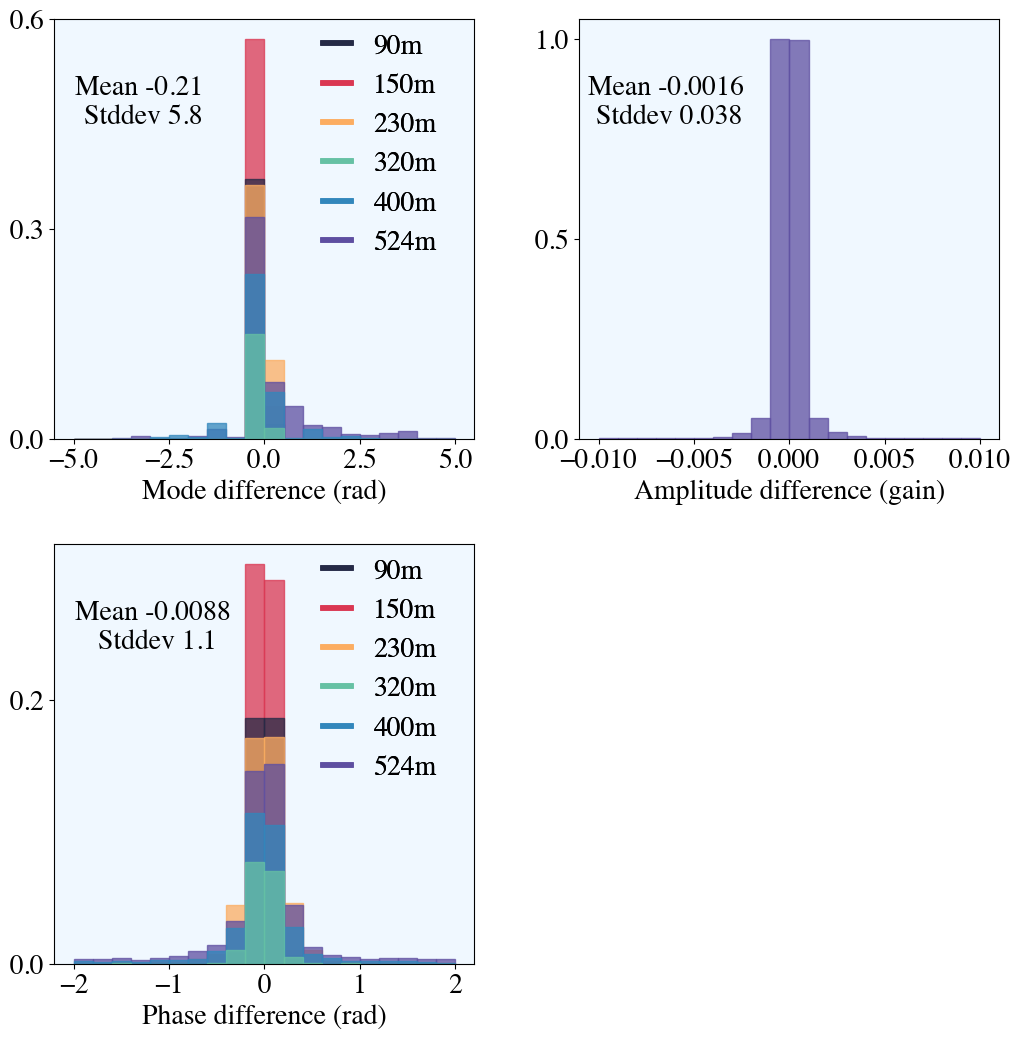

In [322]:


fig = plt.figure(figsize=(21,21))
hist_color=['e','g','h','i','j','k']
plt.rcParams.update({'axes.facecolor':'aliceblue'})
plt.rcParams.update({'font.size': 20})

xmin = .1
ymax = .9
xspace = .2
subplot_loc = np.zeros((4,6))
subplot_loc[:,0] = [xmin,ymax,xspace,xspace]
subplot_loc[:,1] = [xmin+xspace+.05,ymax,xspace,xspace]
subplot_loc[:,2] = [xmin,ymax-xspace-.05,xspace,xspace]
subplot_loc[:,3] = [xmin+xspace+.05,ymax-xspace-.05,xspace,xspace]
subplot_loc[:,4] = [xmin,ymax-2*(xspace+.05),xspace,xspace]
subplot_loc[:,5] = [xmin+xspace+.05,ymax-2*(xspace+.05),xspace,xspace]

######### Mode
binsize=.5
min_bin=-5
max_bin=5
bins = np.arange(min_bin, max_bin + binsize, binsize)
hist, bin_edges = np.histogram(cable_mode, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.axes(subplot_loc[:,0])
#plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])

hist, bin_edges = np.histogram(cable_mode[:,:,cable150_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[4], alpha = 0.75, edgecolor=hist_color[4])
hist, bin_edges = np.histogram(cable_mode[:,:,cable90_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[5], alpha = 0.75, edgecolor=hist_color[5])
hist, bin_edges = np.histogram(cable_mode[:,:,cable230_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[3], alpha = 0.75, edgecolor=hist_color[3])
hist, bin_edges = np.histogram(cable_mode[:,:,cable524_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
hist, bin_edges = np.histogram(cable_mode[:,:,cable400_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1])
hist, bin_edges = np.histogram(cable_mode[:,:,cable320_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])


plt.xlabel('Mode difference (rad)',fontsize=20)
plt.yticks([0.0,0.3,0.6])

mean = np.nanmean(cable_mode)
sigma = np.nanstd(cable_mode)

# Legend
fig.text(.11, 1.05, f'Mean {"{0:.2g}".format(mean)}\n Stddev {"{0:.2g}".format(sigma)}',rotation='horizontal',
        multialignment='center',fontsize=20,fontproperties=font)

# Legend
linestyle = ['solid','solid','solid','solid','solid','solid']
f1_label = ['90m','150m','230m','320m','400m','524m']
patches = [ plt.plot([],[], mec=None, color=hist_color[5 - type_i], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .7),loc='center', ncol=1, frameon=False,
            fontsize=20,title_fontsize=45,handlelength=1)
legend2._legend_box.align='left'
# change the line width for the legend
for line in legend2.get_lines():
    line.set_linewidth(4.0)
a2=plt.gca()
a2.add_artist(legend2)

######### Amp
binsize=.001
min_bin=-.01
max_bin=.01
bins = np.arange(min_bin, max_bin + binsize, binsize)
hist, bin_edges = np.histogram(cable_amp, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.axes(subplot_loc[:,1])
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
plt.xlabel('Amplitude difference (gain)',fontsize=20)
plt.yticks([0.0,0.5,1.0])

mean = np.nanmean(cable_amp)
sigma = np.nanstd(cable_amp)

# Legend
fig.text(.354, 1.05, f'Mean {"{0:.2g}".format(mean)}\n Stddev {"{0:.2g}".format(sigma)}',rotation='horizontal',
        multialignment='center',fontsize=20,fontproperties=font)

######### Phase
binsize=.2
min_bin=-2
max_bin=2
bins = np.arange(min_bin, max_bin + binsize, binsize)
all_hist, bin_edges = np.histogram(cable_phase, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.axes(subplot_loc[:,2])

hist, bin_edges = np.histogram(cable_phase[:,:,cable150_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[4], alpha = 0.75, edgecolor=hist_color[4])
hist, bin_edges = np.histogram(cable_phase[:,:,cable90_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[5], alpha = 0.75, edgecolor=hist_color[5])
hist, bin_edges = np.histogram(cable_phase[:,:,cable230_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[3], alpha = 0.75, edgecolor=hist_color[3])
hist, bin_edges = np.histogram(cable_phase[:,:,cable524_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])
hist, bin_edges = np.histogram(cable_phase[:,:,cable400_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1])
hist, bin_edges = np.histogram(cable_phase[:,:,cable320_inds], bins=bins)
plt.bar(plot_bins, hist/max(all_hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])

plt.xlabel('Phase difference (rad)',fontsize=20)
plt.yticks([0.0,0.2,0.4])

mean = np.nanmean(cable_phase)
sigma = np.nanstd(cable_phase)

# Legend
fig.text(.11, .8, f'Mean {"{0:.2g}".format(mean)}\n Stddev {"{0:.2g}".format(sigma)}',rotation='horizontal',
        multialignment='center',fontsize=20,fontproperties=font)
        
# Legend
linestyle = ['solid','solid','solid','solid','solid','solid']
f1_label = ['90m','150m','230m','320m','400m','524m']
patches = [ plt.plot([],[], mec=None, color=hist_color[5 - type_i], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .7),loc='center', ncol=1, frameon=False,
            fontsize=20,title_fontsize=45,handlelength=1)
legend2._legend_box.align='left'
# change the line width for the legend
for line in legend2.get_lines():
    line.set_linewidth(4.0)
a2=plt.gca()
a2.add_artist(legend2)

cal_list[0]['amp_params']

([<matplotlib.axis.YTick at 0x307825ed0>,
 [Text(0, 0.0, '0.0'), Text(0, 0.5, '0.5'), Text(0, 1.0, '1.0')])

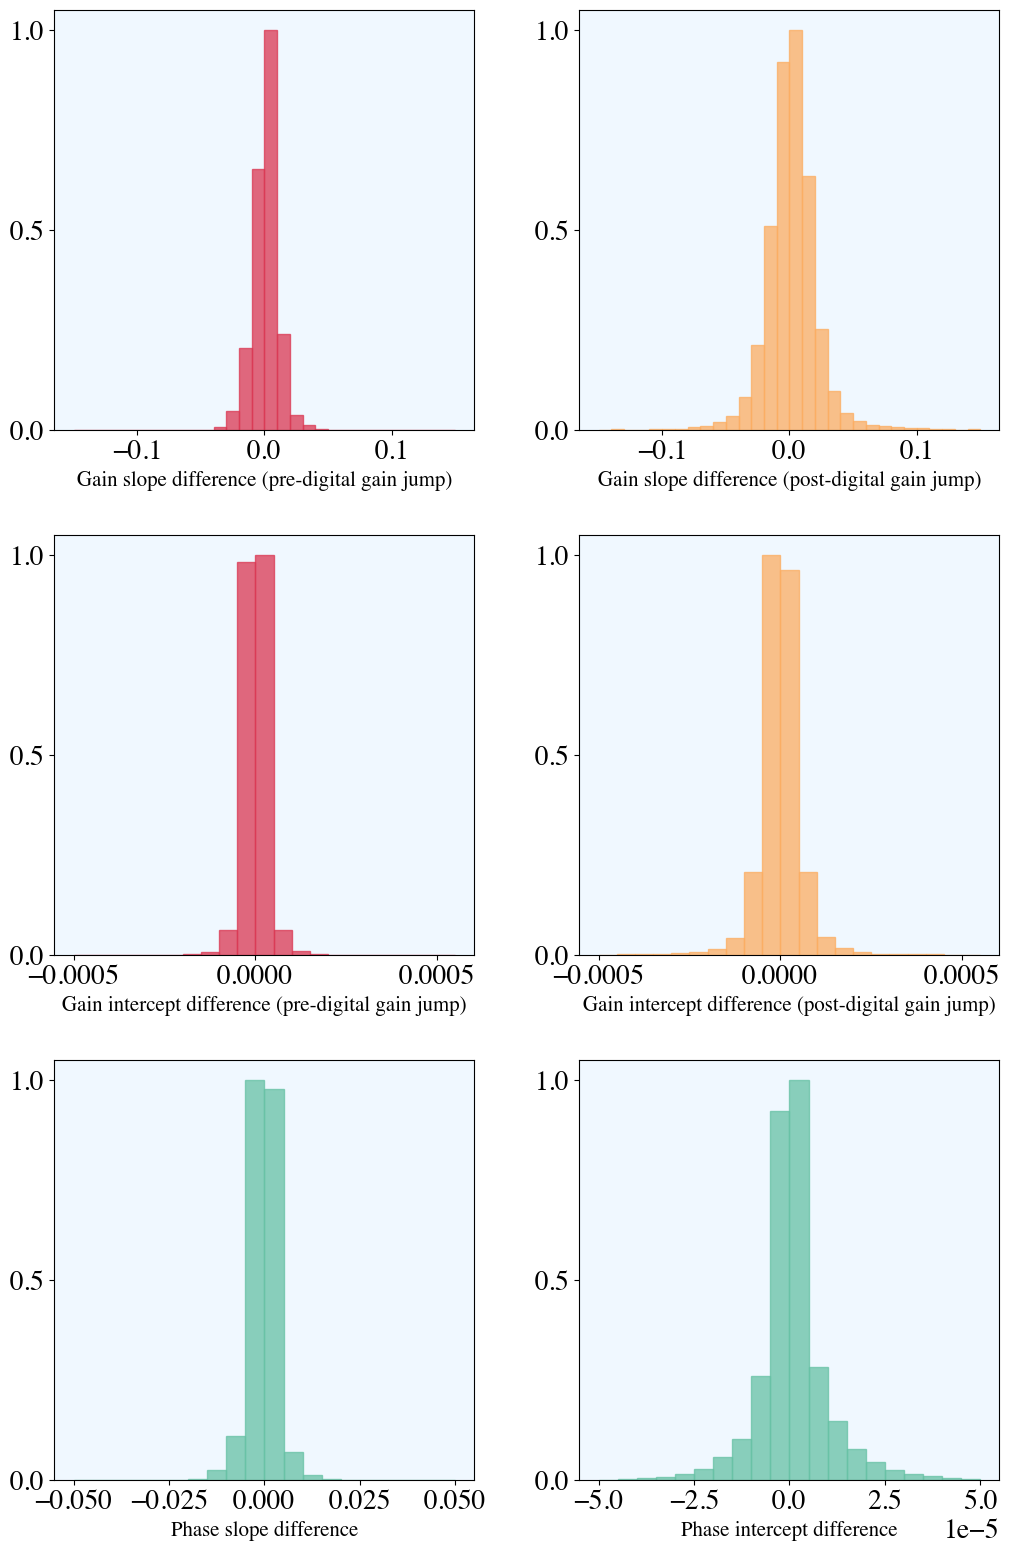

In [377]:
fig = plt.figure(figsize=(21,21))
hist_color=['e','g','h','i','j','k']
plt.rcParams.update({'axes.facecolor':'aliceblue'})
plt.rcParams.update({'font.size': 20})

xmin = .1
ymax = .9
xspace = .2
subplot_loc = np.zeros((4,6))
subplot_loc[:,0] = [xmin,ymax,xspace,xspace]
subplot_loc[:,1] = [xmin+xspace+.05,ymax,xspace,xspace]
subplot_loc[:,2] = [xmin,ymax-xspace-.05,xspace,xspace]
subplot_loc[:,3] = [xmin+xspace+.05,ymax-xspace-.05,xspace,xspace]
subplot_loc[:,4] = [xmin,ymax-2*(xspace+.05),xspace,xspace]
subplot_loc[:,5] = [xmin+xspace+.05,ymax-2*(xspace+.05),xspace,xspace]

######### Amp1
binsize=.01
min_bin=-.15
max_bin=.15
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,0])

hist, bin_edges = np.histogram(amp_slope1, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[4], alpha = 0.75, edgecolor=hist_color[4])

plt.xlabel('Gain slope difference (pre-digital gain jump)',fontsize=15)
plt.yticks([0.0,0.5,1])

######### Amp2
binsize=.01
min_bin=-.15
max_bin=.15
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,1])
hist, bin_edges = np.histogram(amp_slope2, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[3], alpha = 0.75, edgecolor=hist_color[3])

plt.xlabel('Gain slope difference (post-digital gain jump)',fontsize=15)
plt.yticks([0.0,0.5,1])

######### Inter1
binsize=.00005
min_bin=-.0005
max_bin=.0005
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,2])

hist, bin_edges = np.histogram(amp_inter1, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[4], alpha = 0.75, edgecolor=hist_color[4])

plt.xlabel('Gain intercept difference (pre-digital gain jump)',fontsize=15)
plt.yticks([0.0,0.5,1])
plt.xticks([-.0005,0,.0005])

######### Inter2
binsize=.00005
min_bin=-.0005
max_bin=.0005
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,3])
hist, bin_edges = np.histogram(amp_inter2, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[3], alpha = 0.75, edgecolor=hist_color[3])

plt.xlabel('Gain intercept difference (post-digital gain jump)',fontsize=15)
plt.yticks([0.0,0.5,1])
plt.xticks([-.0005,0,.0005])

######### Phase slope
binsize=.005
min_bin=-.05
max_bin=.05
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,4])

hist, bin_edges = np.histogram(phase_slope, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])

plt.xlabel('Phase slope difference',fontsize=15)
plt.yticks([0.0,0.5,1])

######### Phase inter
binsize=.000005
min_bin=-.00005
max_bin=.00005
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,5])

hist, bin_edges = np.histogram(phase_inter, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist/max(hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])

plt.xlabel('Phase intercept difference',fontsize=15)
plt.yticks([0.0,0.5,1])

Text(0.5, 0, 'FHD minus PyFHD')

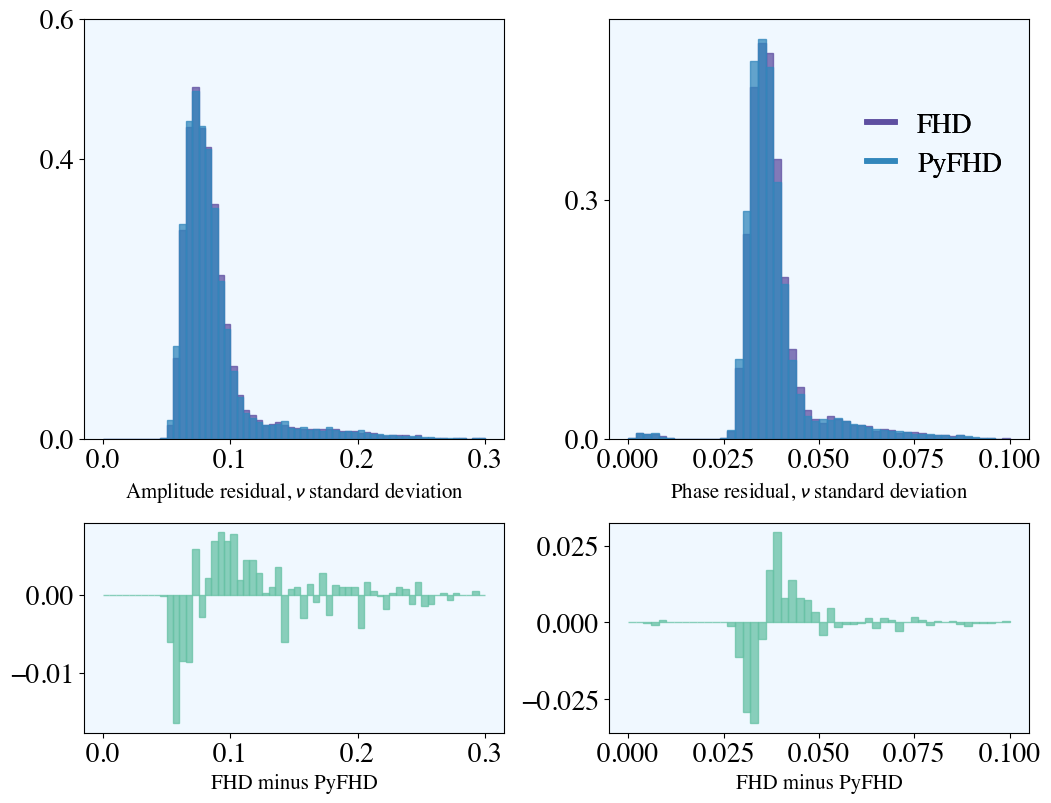

In [21]:
fig = plt.figure(figsize=(21,21))
hist_color=['e','g','h','i','j','k']
plt.rcParams.update({'axes.facecolor':'aliceblue'})
plt.rcParams.update({'font.size': 20})

xmin = .1
ymax = .9
xspace = .2
subplot_loc = np.zeros((4,6))
subplot_loc[:,0] = [xmin,ymax,xspace,xspace]
subplot_loc[:,1] = [xmin+xspace+.05,ymax,xspace,xspace]

#differences
subplot_loc[:,2] = [xmin,ymax-xspace/2-.04,xspace,xspace/2]
subplot_loc[:,3] = [xmin+xspace+.05,ymax-xspace/2-.04,xspace,xspace/2]

res_amp_fhd_list = np.abs(raw_fhd_list) - np.abs(sol_fhd_list)
res_phase_fhd_list = (np.unwrap(np.arctan2(raw_fhd_list.imag, raw_fhd_list.real), axis=2) 
                      - np.unwrap(np.arctan2(sol_fhd_list.imag, sol_fhd_list.real), axis=2))
res_amp_list = np.abs(raw_list) - np.abs(sol_list)
res_phase_list = (np.unwrap(np.arctan2(raw_list.imag, raw_list.real), axis=2) 
                  - np.unwrap(np.arctan2(sol_list.imag, sol_list.real), axis=2))
    
    
res_std = np.nanstd(res_amp_list, axis=2)
res_fhd_std = np.nanstd(res_amp_fhd_list, axis=2)    

res_phase_std = np.nanstd(res_phase_list, axis=2)
res_phase_fhd_std = np.nanstd(res_phase_fhd_list, axis=2)    


######### Amp
binsize=.005
min_bin=0
max_bin=0.3
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,0])

all_hist,bin_edges = np.histogram([res_std,res_fhd_std], bins=bins)

hist_f, bin_edges = np.histogram(res_fhd_std, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_f/max(all_hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])

hist_p, bin_edges = np.histogram(res_std, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_p/max(all_hist), width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1])

plt.xlabel('Amplitude residual, $\\nu$ standard deviation',fontsize=15)
plt.yticks([0.0,0.4,.6])

plt.axes(subplot_loc[:,2])
plt.bar(plot_bins, (hist_f- hist_p)/max(all_hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])
plt.xlabel('FHD minus PyFHD',fontsize=15)

######### Phase
binsize=.002
min_bin=-0
max_bin=.1
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,1])

all_hist,bin_edges = np.histogram([res_phase_std,res_phase_fhd_std], bins=bins)

hist_f, bin_edges = np.histogram(res_phase_fhd_std, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_f/max(all_hist), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])

hist_p, bin_edges = np.histogram(res_phase_std, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_p/max(all_hist), width=width, color=hist_color[1], alpha = 0.75, edgecolor=hist_color[1])

plt.xlabel('Phase residual, $\\nu$ standard deviation',fontsize=15)
plt.yticks([0.0,0.3,.6])

# Legend
linestyle = ['solid','solid']
f1_label = ['FHD','PyFHD']
patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .7),loc='center', ncol=1, frameon=False,
            fontsize=20,title_fontsize=45,handlelength=1)
legend2._legend_box.align='left'
# change the line width for the legend
for line in legend2.get_lines():
    line.set_linewidth(4.0)
a2=plt.gca()
a2.add_artist(legend2)

plt.axes(subplot_loc[:,3])
plt.bar(plot_bins, (hist_f- hist_p)/max(all_hist), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])
plt.xlabel('FHD minus PyFHD',fontsize=15)

Text(0.5, 1.0, 'Statistics, FHD vs PyFHD')

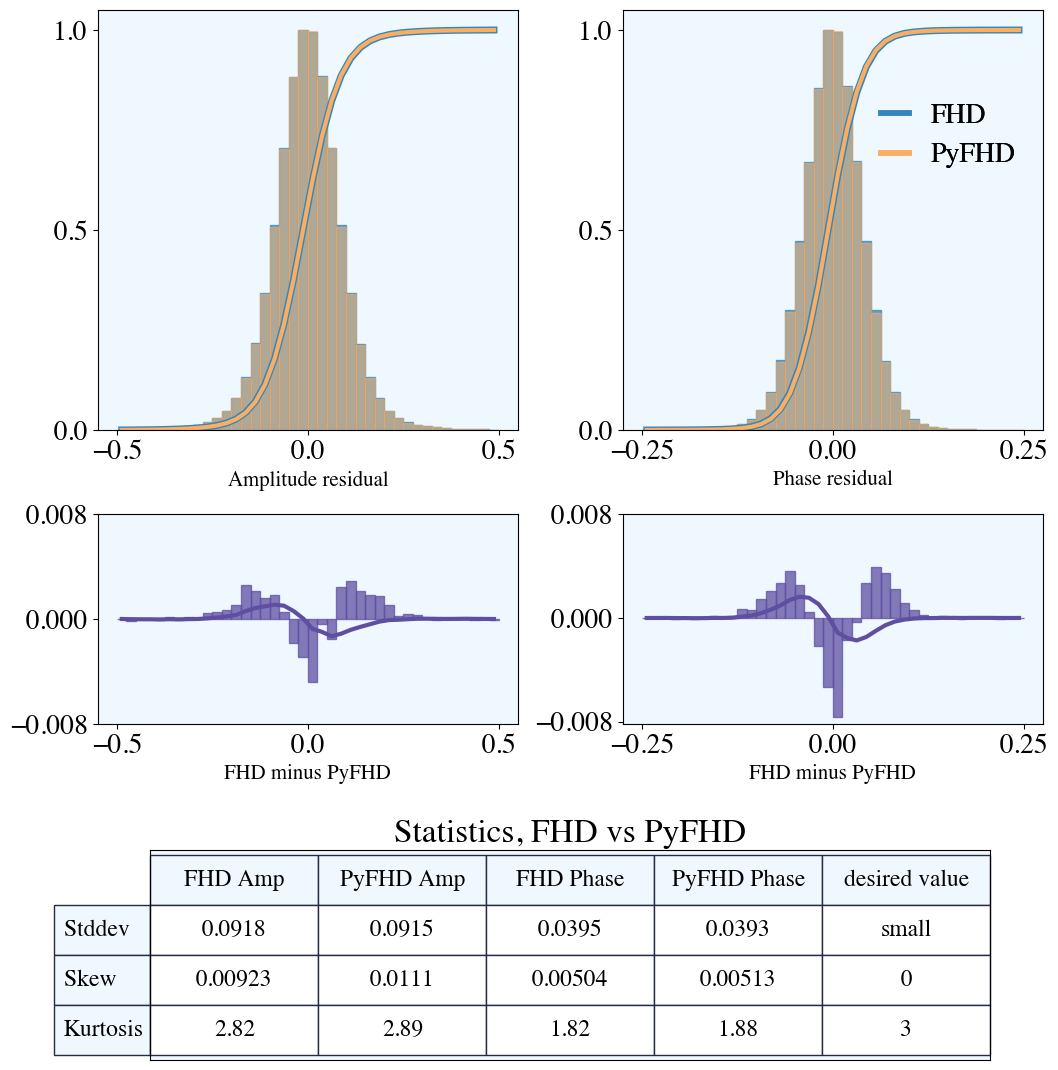

In [89]:
fig = plt.figure(figsize=(21,21))
hist_color=['g','i','e','h','j','k']
plt.rcParams.update({'axes.facecolor':'aliceblue'})
plt.rcParams.update({'font.size': 20})

xmin = .1
ymax = .9
xspace = .2
subplot_loc = np.zeros((4,6))
subplot_loc[:,0] = [xmin,ymax,xspace,xspace]
subplot_loc[:,1] = [xmin+xspace+.05,ymax,xspace,xspace]

#differences
subplot_loc[:,2] = [xmin,ymax-xspace/2-.04,xspace,xspace/2]
subplot_loc[:,3] = [xmin+xspace+.05,ymax-xspace/2-.04,xspace,xspace/2]

# Table
subplot_loc[:,4] = [xmin+(.05)/2,ymax-xspace*3/2,xspace*2,xspace/2]

res_amp_fhd_list = np.abs(raw_fhd_list) - np.abs(sol_fhd_list)
res_phase_fhd_list = (np.unwrap(np.arctan2(raw_fhd_list.imag, raw_fhd_list.real), axis=2) 
                      - np.unwrap(np.arctan2(sol_fhd_list.imag, sol_fhd_list.real), axis=2))
res_amp_list = np.abs(raw_list) - np.abs(sol_list)
res_phase_list = (np.unwrap(np.arctan2(raw_list.imag, raw_list.real), axis=2) 
                  - np.unwrap(np.arctan2(sol_list.imag, sol_list.real), axis=2))

########### Stats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm


res_amp_fhd_nn = res_amp_fhd_list[~np.isnan(res_amp_fhd_list)]
res_amp_fhd_nn = res_amp_fhd_nn[np.nonzero(res_amp_fhd_nn)]
res_amp_fhd_nn = res_amp_fhd_nn[(res_amp_fhd_nn < .75) & (res_amp_fhd_nn > -.75)]

res_phase_fhd_nn = res_phase_fhd_list[~np.isnan(res_phase_fhd_list)]
res_phase_fhd_nn = res_phase_fhd_nn[np.nonzero(res_phase_fhd_nn)]
res_phase_fhd_nn = res_phase_fhd_nn[(res_phase_fhd_nn < .75) & (res_phase_fhd_nn > -.75)]

res_amp_pyfhd_nn = res_amp_list[~np.isnan(res_amp_list)]
res_amp_pyfhd_nn = res_amp_pyfhd_nn[np.nonzero(res_amp_pyfhd_nn)]
res_amp_pyfhd_nn = res_amp_pyfhd_nn[(res_amp_pyfhd_nn < .75) & (res_amp_pyfhd_nn > -.75)]

res_phase_pyfhd_nn = res_phase_list[~np.isnan(res_phase_list)]
res_phase_pyfhd_nn = res_phase_pyfhd_nn[np.nonzero(res_phase_pyfhd_nn)]
res_phase_pyfhd_nn = res_phase_pyfhd_nn[(res_phase_pyfhd_nn < .75) & (res_phase_pyfhd_nn > -.75)]

(mu_amp_fhd, sigma_amp_fhd) = norm.fit(res_amp_fhd_nn)
(mu_phase_fhd, sigma_phase_fhd) = norm.fit(res_phase_fhd_nn)
(mu_amp_pyfhd, sigma_amp_pyfhd) = norm.fit(res_amp_pyfhd_nn)
(mu_phase_pyfhd, sigma_phase_pyfhd) = norm.fit(res_phase_pyfhd_nn)

skew_amp_fhd = skew(res_amp_fhd_nn, axis=None)
skew_phase_fhd = skew(res_phase_fhd_nn, axis=None)
skew_amp_pyfhd = skew(res_amp_pyfhd_nn, axis=None)
skew_phase_pyfhd = skew(res_phase_pyfhd_nn, axis=None)

kurt_amp_fhd = kurtosis(res_amp_fhd_nn, axis=None)
kurt_phase_fhd = kurtosis(res_phase_fhd_nn, axis=None)
kurt_amp_pyfhd = kurtosis(res_amp_pyfhd_nn, axis=None)
kurt_phase_pyfhd = kurtosis(res_phase_pyfhd_nn, axis=None)


######### Amp
binsize=.025
min_bin=-0.5
max_bin=0.5
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,0])

hist_f, bin_edges = np.histogram(res_amp_fhd_list, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_f/max(hist_f), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])

cdf_f = np.cumsum(hist_f/sum(hist_f))
plt.plot(plot_bins, cdf_f,'-', color=hist_color[0],linewidth=5)

hist_p, bin_edges = np.histogram(res_amp_list, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_p/max(hist_p), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1])

cdf_p = np.cumsum(hist_p/sum(hist_p))
plt.plot(plot_bins, cdf_p,'-', color=hist_color[1],linewidth=3)

plt.xlabel('Amplitude residual',fontsize=15)

plt.yticks([0.0,0.5,1])
plt.xticks([-0.5,0,0.5])

plt.axes(subplot_loc[:,2])
plt.bar(plot_bins, (hist_f- hist_p)/max(hist_p), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])
plt.plot(plot_bins, cdf_f - cdf_p,'-', color=hist_color[2],linewidth=3)
plt.xlabel('FHD minus PyFHD',fontsize=15)

plt.yticks([-0.008,0,0.008])
plt.xticks([-0.5,0,0.5])

######### Phase
binsize=.0125
min_bin=-.25
max_bin=.25
bins = np.arange(min_bin, max_bin + binsize, binsize)
plt.axes(subplot_loc[:,1])

all_hist,bin_edges = np.histogram([res_phase_std,res_phase_fhd_std], bins=bins)

hist_f, bin_edges = np.histogram(res_phase_fhd_list, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_f/max(hist_f), width=width, color=hist_color[0], alpha = 0.75, edgecolor=hist_color[0])

cdf_f = np.cumsum(hist_f/sum(hist_f))
plt.plot(plot_bins, cdf_f,'-', color=hist_color[0],linewidth=5)

hist_p, bin_edges = np.histogram(res_phase_list, bins=bins)
width = (bin_edges[1]- bin_edges[0])
plot_bins = bin_edges[1:]-width/2
plt.bar(plot_bins, hist_p/max(hist_p), width=width, color=hist_color[1], alpha = 0.5, edgecolor=hist_color[1])

cdf_p = np.cumsum(hist_p/sum(hist_p))
plt.plot(plot_bins, cdf_p,'-', color=hist_color[1],linewidth=3)

plt.xlabel('Phase residual',fontsize=15)
plt.yticks([0.0,0.5,1])
plt.xticks([-0.25,0,0.25])

# Legend
linestyle = ['solid','solid']
f1_label = ['FHD','PyFHD']
patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
legend2 = plt.legend(handles=patches, bbox_to_anchor=(.775, .7),loc='center', ncol=1, frameon=False,
            fontsize=20,title_fontsize=45,handlelength=1)
legend2._legend_box.align='left'
# change the line width for the legend
for line in legend2.get_lines():
    line.set_linewidth(4.0)
a2=plt.gca()
a2.add_artist(legend2)

plt.axes(subplot_loc[:,3])
plt.bar(plot_bins, (hist_f- hist_p)/max(hist_p), width=width, color=hist_color[2], alpha = 0.75, edgecolor=hist_color[2])
plt.plot(plot_bins, cdf_f - cdf_p,'-', color=hist_color[2],linewidth=3)
plt.xlabel('FHD minus PyFHD',fontsize=15)

plt.yticks([-0.008,0,0.008])
plt.xticks([-0.25,0,0.25])

# for table
plt.axes(subplot_loc[:,4])
#plt.plot([], [])
plt.yticks([])
plt.xticks([])

# Legend
#fig.text(.21, .65, f'Stddev: Amp {"{0:.2g}".format(sigma_amp_fhd - sigma_amp_pyfhd)}, Phase {"{0:.2g}".format(sigma_phase_fhd - sigma_phase_pyfhd)}\n' +
#         f'Skew: Amp {"{0:.2g}".format(skew_amp_fhd - skew_amp_pyfhd)}, Phase {"{0:.2g}".format(skew_phase_fhd - skew_phase_pyfhd)}\n' +
#         f'Kurtosis: Amp {"{0:.2g}".format(kurt_amp_fhd - kurt_amp_pyfhd)}, Phase {"{0:.2g}".format(kurt_phase_fhd - kurt_phase_pyfhd)}',
#        multialignment='center',fontsize=20,fontproperties=font)

table = plt.table( 
    cellText = [["{0:.3g}".format(sigma_amp_fhd),"{0:.3g}".format(sigma_amp_pyfhd),"{0:.3g}".format(sigma_phase_fhd),"{0:.3g}".format(sigma_phase_pyfhd), 'small'],
               ["{0:.3g}".format(skew_amp_fhd),"{0:.3g}".format(skew_amp_pyfhd),"{0:.3g}".format(skew_phase_fhd),"{0:.3g}".format(skew_phase_pyfhd), 0],
               ["{0:.3g}".format(kurt_amp_fhd),"{0:.3g}".format(kurt_amp_pyfhd),"{0:.3g}".format(kurt_phase_fhd),"{0:.3g}".format(kurt_phase_pyfhd), 3]],  
    rowLabels = ['Stddev', 'Skew', 'Kurtosis'],  
    colLabels = ['FHD Amp', 'PyFHD Amp', 'FHD Phase', 'PyFHD Phase', 'desired value'], 
    rowColours =["aliceblue"] * 3,  
    colColours =["aliceblue"] * 5, 
    cellLoc ='center',  
    loc ='center')  
table.scale(1, 3)
plt.title('Statistics, FHD vs PyFHD')


# print(sigma_amp_fhd, sigma_amp_pyfhd)
# print(sigma_phase_fhd, sigma_phase_pyfhd)
# print(skew_amp_fhd, skew_amp_pyfhd)
# print(skew_phase_fhd, skew_phase_pyfhd)
# print(kurt_amp_fhd, kurt_amp_pyfhd)
# print(kurt_phase_fhd, kurt_phase_pyfhd)